In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    channel_size = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 128)        49280     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 128)        49280     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 128)        49280     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0134 - acc: 0.4604
Epoch 00001: val_loss improved from inf to 1.57889, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_4_conv_checkpoint/001-1.5789.hdf5
36805/36805 [==============================] - 293s 8ms/sample - loss: 2.0136 - acc: 0.4603 - val_loss: 1.5789 - val_acc: 0.5660
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1578 - acc: 0.6737
Epoch 00002: val_loss improved from 1.57889 to 1.44796, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_4_conv_checkpoint/002-1.4480.hdf5
36805/36805 [==============================] - 289s 8ms/sample - loss: 1.1581 - acc: 0.6736 - val_loss: 1.4480 - val_acc: 0.6131
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6990 - acc: 0.7919
Epoch 00003: val_loss improved from 1.44796 t

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9861
Epoch 00029: val_loss did not improve from 1.30666
36805/36805 [==============================] - 290s 8ms/sample - loss: 0.0525 - acc: 0.9860 - val_loss: 2.0503 - val_acc: 0.6753
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9879
Epoch 00030: val_loss did not improve from 1.30666
36805/36805 [==============================] - 290s 8ms/sample - loss: 0.0497 - acc: 0.9878 - val_loss: 2.2438 - val_acc: 0.6646
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0643 - acc: 0.9840
Epoch 00031: val_loss did not improve from 1.30666
36805/36805 [==============================] - 290s 8ms/sample - loss: 0.0643 - acc: 0.9840 - val_loss: 2.0527 - val_acc: 0.6823
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9919
Epoch 00032: val_loss did not improve from 1.30666
36805/36805 [========

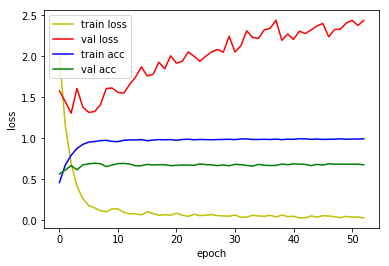

4815/4815 [==============================] - 16s 3ms/sample - loss: 1.4796 - acc: 0.6258
Loss: 1.4795852784427155 Accuracy: 0.62575287

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8160 - acc: 0.4939
Epoch 00001: val_loss improved from inf to 1.58095, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_5_conv_checkpoint/001-1.5810.hdf5
36805/36805 [==============================] - 306s 8ms/sample - loss: 1.8164 - acc: 0.4938 - val_loss: 1.5810 - val_acc: 0.5821
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1116 - acc: 0.6862
Epoch 00002: val_loss improved from 1.58095 to 1.17622, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_5_conv_checkpoint/002-1.1762.hdf5
36805/36805 [==============================] - 299s 8ms/sample - loss: 1.1116 - acc: 0.6862 - val_loss: 1.1762 - val_acc: 0.6967
Epoch 3/500
36800/36805 [============================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0809 - acc: 0.9774
Epoch 00029: val_loss did not improve from 1.05238
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.0813 - acc: 0.9774 - val_loss: 1.3715 - val_acc: 0.7568
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9833
Epoch 00030: val_loss did not improve from 1.05238
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.0634 - acc: 0.9832 - val_loss: 1.2833 - val_acc: 0.7678
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9814
Epoch 00031: val_loss did not improve from 1.05238
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.0682 - acc: 0.9814 - val_loss: 1.4749 - val_acc: 0.7510
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9884
Epoch 00032: val_loss did not improve from 1.05238
36805/36805 [========

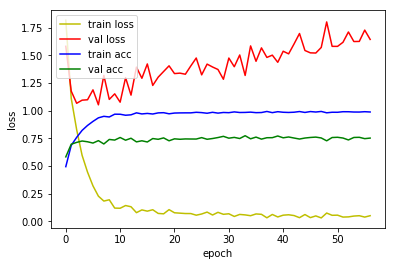

4815/4815 [==============================] - 17s 3ms/sample - loss: 1.1398 - acc: 0.7034
Loss: 1.1398343253110923 Accuracy: 0.7034268

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6820 - acc: 0.4935
Epoch 00001: val_loss improved from inf to 1.13120, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_6_conv_checkpoint/001-1.1312.hdf5
36805/36805 [==============================] - 313s 9ms/sample - loss: 1.6821 - acc: 0.4935 - val_loss: 1.1312 - val_acc: 0.6643
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9991 - acc: 0.7043
Epoch 00002: val_loss improved from 1.13120 to 0.88594, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_6_conv_checkpoint/002-0.8859.hdf5
36805/36805 [==============================] - 303s 8ms/sample - loss: 0.9992 - acc: 0.7043 - val_loss: 0.8859 - val_acc: 0.7526
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0789 - acc: 0.9768
Epoch 00026: val_loss did not improve from 0.48552
36805/36805 [==============================] - 303s 8ms/sample - loss: 0.0791 - acc: 0.9767 - val_loss: 0.5821 - val_acc: 0.8758
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9804
Epoch 00027: val_loss did not improve from 0.48552
36805/36805 [==============================] - 303s 8ms/sample - loss: 0.0679 - acc: 0.9803 - val_loss: 0.5595 - val_acc: 0.8807
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9783
Epoch 00028: val_loss improved from 0.48552 to 0.47951, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_6_conv_checkpoint/028-0.4795.hdf5
36805/36805 [==============================] - 304s 8ms/sample - loss: 0.0716 - acc: 0.9783 - val_loss: 0.4795 - val_acc: 0.8968
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9868
Epoch 00055: val_loss did not improve from 0.47951
36805/36805 [==============================] - 303s 8ms/sample - loss: 0.0445 - acc: 0.9868 - val_loss: 0.5705 - val_acc: 0.8954
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9904
Epoch 00056: val_loss did not improve from 0.47951
36805/36805 [==============================] - 301s 8ms/sample - loss: 0.0331 - acc: 0.9903 - val_loss: 0.5465 - val_acc: 0.8963
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9880
Epoch 00057: val_loss did not improve from 0.47951
36805/36805 [==============================] - 301s 8ms/sample - loss: 0.0399 - acc: 0.9880 - val_loss: 0.5971 - val_acc: 0.8898
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9939
Epoch 00058: val_loss did not improve from 0.47951
36805/36805 [=====================

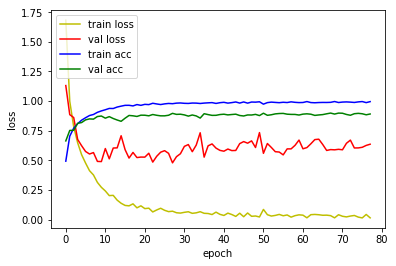

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.5696 - acc: 0.8663
Loss: 0.5696179456180996 Accuracy: 0.8662513

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6560 - acc: 0.4955
Epoch 00001: val_loss improved from inf to 1.00879, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_7_conv_checkpoint/001-1.0088.hdf5
36805/36805 [==============================] - 320s 9ms/sample - loss: 1.6562 - acc: 0.4955 - val_loss: 1.0088 - val_acc: 0.7028
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8889 - acc: 0.7378
Epoch 00002: val_loss improved from 1.00879 to 0.73769, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_7_conv_checkpoint/002-0.7377.hdf5
36805/36805 [==============================] - 309s 8ms/sample - loss: 0.8891 - acc: 0.7378 - val_loss: 0.7377 - val_acc: 0.7873
Epoch 3/500
36800/36805 [============================>

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9808
Epoch 00027: val_loss did not improve from 0.22528
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0617 - acc: 0.9807 - val_loss: 0.2557 - val_acc: 0.9380
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9871
Epoch 00028: val_loss did not improve from 0.22528
36805/36805 [==============================] - 310s 8ms/sample - loss: 0.0459 - acc: 0.9870 - val_loss: 0.2355 - val_acc: 0.9455
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9832
Epoch 00029: val_loss did not improve from 0.22528
36805/36805 [==============================] - 309s 8ms/sample - loss: 0.0563 - acc: 0.9831 - val_loss: 0.3614 - val_acc: 0.9080
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9815
Epoch 00030: val_loss did not improve from 0.22528
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9873
Epoch 00056: val_loss improved from 0.21129 to 0.20910, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_7_conv_checkpoint/056-0.2091.hdf5
36805/36805 [==============================] - 312s 8ms/sample - loss: 0.0434 - acc: 0.9873 - val_loss: 0.2091 - val_acc: 0.9539
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9971
Epoch 00057: val_loss did not improve from 0.20910
36805/36805 [==============================] - 309s 8ms/sample - loss: 0.0120 - acc: 0.9971 - val_loss: 0.2912 - val_acc: 0.9408
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9912
Epoch 00058: val_loss did not improve from 0.20910
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0277 - acc: 0.9912 - val_loss: 0.2417 - val_acc: 0.9460
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9954
Epoch 00085: val_loss did not improve from 0.20910
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0147 - acc: 0.9953 - val_loss: 0.2145 - val_acc: 0.9576
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9964
Epoch 00086: val_loss did not improve from 0.20910
36805/36805 [==============================] - 310s 8ms/sample - loss: 0.0139 - acc: 0.9963 - val_loss: 0.2705 - val_acc: 0.9471
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9946
Epoch 00087: val_loss did not improve from 0.20910
36805/36805 [==============================] - 309s 8ms/sample - loss: 0.0174 - acc: 0.9946 - val_loss: 0.2580 - val_acc: 0.9525
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9976
Epoch 00088: val_loss did not improve from 0.20910
36805/36805 [=====================

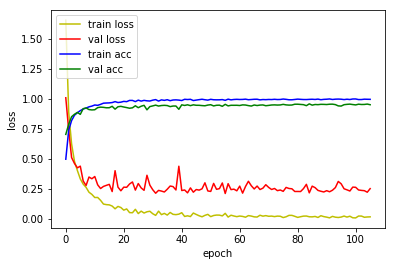

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2327 - acc: 0.9427
Loss: 0.23270402601837864 Accuracy: 0.9426791

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4316 - acc: 0.5655
Epoch 00001: val_loss improved from inf to 0.67747, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_8_conv_checkpoint/001-0.6775.hdf5
36805/36805 [==============================] - 321s 9ms/sample - loss: 1.4317 - acc: 0.5654 - val_loss: 0.6775 - val_acc: 0.8027
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5782 - acc: 0.8309
Epoch 00002: val_loss improved from 0.67747 to 0.44925, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_8_conv_checkpoint/002-0.4493.hdf5
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.5784 - acc: 0.8309 - val_loss: 0.4493 - val_acc: 0.8642
Epoch 3/500
36800/36805 [============================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9932
Epoch 00026: val_loss did not improve from 0.14005
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0265 - acc: 0.9931 - val_loss: 0.1588 - val_acc: 0.9599
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9835
Epoch 00027: val_loss did not improve from 0.14005
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0519 - acc: 0.9835 - val_loss: 0.1443 - val_acc: 0.9597
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9926
Epoch 00028: val_loss did not improve from 0.14005
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0267 - acc: 0.9926 - val_loss: 0.1446 - val_acc: 0.9630
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9910
Epoch 00029: val_loss did not improve from 0.14005
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9979
Epoch 00055: val_loss did not improve from 0.12957
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0088 - acc: 0.9978 - val_loss: 0.1574 - val_acc: 0.9632
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9942
Epoch 00056: val_loss did not improve from 0.12957
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0191 - acc: 0.9942 - val_loss: 0.1359 - val_acc: 0.9683
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9970
Epoch 00057: val_loss improved from 0.12957 to 0.11967, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_8_conv_checkpoint/057-0.1197.hdf5
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0112 - acc: 0.9970 - val_loss: 0.1197 - val_acc: 0.9706
Epoch 58/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9968
Epoch 00084: val_loss did not improve from 0.11967
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0103 - acc: 0.9968 - val_loss: 0.1419 - val_acc: 0.9686
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9990
Epoch 00085: val_loss did not improve from 0.11967
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0048 - acc: 0.9990 - val_loss: 0.1402 - val_acc: 0.9676
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9961
Epoch 00086: val_loss did not improve from 0.11967
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0132 - acc: 0.9961 - val_loss: 0.1656 - val_acc: 0.9634
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9981
Epoch 00087: val_loss did not improve from 0.11967
36805/36805 [=====================

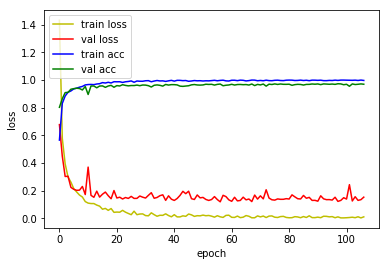

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.1532 - acc: 0.9597
Loss: 0.1532023442385434 Accuracy: 0.9597092

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1167 - acc: 0.6484
Epoch 00001: val_loss improved from inf to 0.43703, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_9_conv_checkpoint/001-0.4370.hdf5
36805/36805 [==============================] - 327s 9ms/sample - loss: 1.1167 - acc: 0.6484 - val_loss: 0.4370 - val_acc: 0.8591
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4237 - acc: 0.8667
Epoch 00002: val_loss improved from 0.43703 to 0.31721, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_9_conv_checkpoint/002-0.3172.hdf5
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.4238 - acc: 0.8666 - val_loss: 0.3172 - val_acc: 0.9038
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9902
Epoch 00026: val_loss did not improve from 0.12397
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0309 - acc: 0.9901 - val_loss: 0.1464 - val_acc: 0.9604
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9889
Epoch 00027: val_loss did not improve from 0.12397
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0353 - acc: 0.9889 - val_loss: 0.1341 - val_acc: 0.9632
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9907
Epoch 00028: val_loss did not improve from 0.12397
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0297 - acc: 0.9906 - val_loss: 0.1243 - val_acc: 0.9648
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9935
Epoch 00029: val_loss did not improve from 0.12397
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9952
Epoch 00055: val_loss did not improve from 0.12016
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0151 - acc: 0.9952 - val_loss: 0.1532 - val_acc: 0.9655
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9968
Epoch 00056: val_loss did not improve from 0.12016
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0115 - acc: 0.9968 - val_loss: 0.1553 - val_acc: 0.9648
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9967
Epoch 00057: val_loss did not improve from 0.12016
36805/36805 [==============================] - 309s 8ms/sample - loss: 0.0104 - acc: 0.9967 - val_loss: 0.1843 - val_acc: 0.9574
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9958
Epoch 00058: val_loss did not improve from 0.12016
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9987
Epoch 00084: val_loss improved from 0.11328 to 0.11280, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_BN_9_conv_checkpoint/084-0.1128.hdf5
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0045 - acc: 0.9988 - val_loss: 0.1128 - val_acc: 0.9702
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.11280
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0027 - acc: 0.9993 - val_loss: 0.1588 - val_acc: 0.9665
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9963
Epoch 00086: val_loss did not improve from 0.11280
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0119 - acc: 0.9963 - val_loss: 0.1352 - val_acc: 0.9679
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9976
Epoch 00113: val_loss did not improve from 0.11280
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0082 - acc: 0.9976 - val_loss: 0.1483 - val_acc: 0.9672
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9966
Epoch 00114: val_loss did not improve from 0.11280
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0107 - acc: 0.9966 - val_loss: 0.1197 - val_acc: 0.9718
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9992
Epoch 00115: val_loss did not improve from 0.11280
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0038 - acc: 0.9991 - val_loss: 0.1292 - val_acc: 0.9697
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9979
Epoch 00116: val_loss did not improve from 0.11280
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.9996
Epoch 00142: val_loss did not improve from 0.11231
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0017 - acc: 0.9995 - val_loss: 0.1287 - val_acc: 0.9718
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9970
Epoch 00143: val_loss did not improve from 0.11231
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0097 - acc: 0.9970 - val_loss: 0.1160 - val_acc: 0.9737
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9993
Epoch 00144: val_loss did not improve from 0.11231
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0025 - acc: 0.9993 - val_loss: 0.1351 - val_acc: 0.9725
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9995
Epoch 00145: val_loss did not improve from 0.11231
36805/36805 [==================

Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9979
Epoch 00172: val_loss did not improve from 0.11231
36805/36805 [==============================] - 308s 8ms/sample - loss: 0.0070 - acc: 0.9979 - val_loss: 0.1451 - val_acc: 0.9688
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9997
Epoch 00173: val_loss did not improve from 0.11231
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0015 - acc: 0.9996 - val_loss: 0.1360 - val_acc: 0.9730
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9983
Epoch 00174: val_loss did not improve from 0.11231
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.0066 - acc: 0.9983 - val_loss: 0.1337 - val_acc: 0.9706
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9997
Epoch 00175: val_loss did not improve from 0.11231
36805/36805 [====

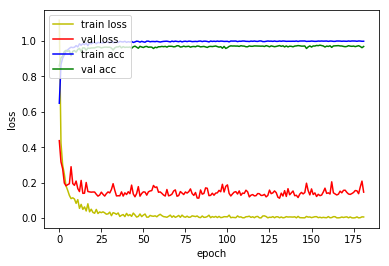

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1473 - acc: 0.9639
Loss: 0.14725198276757542 Accuracy: 0.96386296



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_128_BN'

for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_128_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1865104     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.1532 - acc: 0.9597
Loss: 0.1532023442385434 Accuracy: 0.9597092

1D_CNN_custom_conv_3_VGG_ch_128_BN_9_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_150_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Sequential

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_128_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1865104     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 20s 4ms/sample - loss: 0.1799 - acc: 0.9605
Loss: 0.17989624534375281 Accuracy: 0.96054

1D_CNN_custom_conv_3_VGG_ch_128_BN_9_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_150_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Sequential)